In [1]:
import os
import sys

sys.path.append('../txf_design-space/')
sys.path.append('../txf_design-space/flexibert')
sys.path.append('../protran/boshnas/boshnas/')
sys.path.append('../global_search/utils')
sys.path.append('../')

import re
import yaml
import json
import time
import torch
import shlex
import shutil
import argparse
import subprocess
import collections
import itertools
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm, tqdm_notebook
from matplotlib import pyplot as plt

from embeddings.utils import graph_util, print_util as pu

sys.path.append('../txf_design-space/transformers/src/transformers')
import embedding_util

from boshnas import BOSHNAS
from acq import gosh_acq as acq

from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular, BertForSequenceClassificationModular

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge, LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, ndcg_score

from six.moves import cPickle as pickle
from scipy.interpolate import griddata
from sklearn.tree import plot_tree
from scipy.optimize import minimize, differential_evolution

import lightgbm

PREFIX_CHECKPOINT_DIR = "checkpoint"

MODEL					TYPE		PARAMS		ITERATIONS	LOSS
f36d5c40c770e4f787c78b43a2a09d78	shallow_narrow	70.20M		1000000		2.4507
e3ea4dd7dab98b7ca6aa439a22e2c669	deep_narrow	111.66M		1000000		3.2495
cc085bb5b433b6808e32bd7d1ff49584	deep_narrow	103.37M		1000000		2.1995
bec578218d4f893fdd754d7497af18d5	deep_narrow	81.76M		304000		7.6951
2a8863139d4ccf931452c5f86c3a5a52	shallow_narrow	37.40M		1000000		3.0133
1d41e1cdd47ac30c570648bcddd22ad1	shallow_narrow	36.56M		1000000		7.6902
49ef529d1cada10c9b92463e129424d4	deep_narrow	74.44M		1000000		2.6352
cbf26e711763f177f534ad38b8c7b8a7	shallow_narrow	63.28M		872500		7.6855
dc7733ef95c734eee308504f5e0a384e	shallow_wide	69.57M		680500		2.798
89ca0068830d26fdebfbc79a501b5f2a	deep_wide	110.78M		110500		3.2337
fb76fc6b9cdde469653ce1d3f163b542	deep_wide	102.34M		321000		2.5883
fb04cff166ed53cb40500c78626889ea	deep_wide	80.72M		182500		7.6942
7cf1bfa8946458f7f6d261b11a9166bf	shallow_wide	37.17M		255000		2.4563
081cb16979c43ce0b68a45650dc2de84	shallow_wide	35.12M		36650

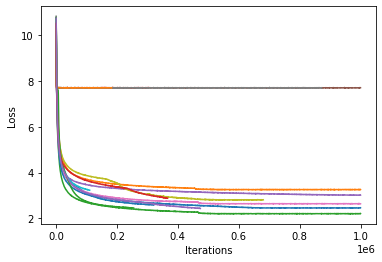

In [2]:
# Get Sobol samples and training status
glob_dataset_file = '../global_search/dataset/dataset.json'
models_dir = '../models/global_search/'

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config = BertConfig(vocab_size = tokenizer.vocab_size)

dataset = json.load(open(glob_dataset_file, 'r'))

X_list, y_list = [], []

print('MODEL\t\t\t\t\tTYPE\t\tPARAMS\t\tITERATIONS\tLOSS')
for model in dataset.keys():
    model_dir = os.path.join(models_dir, model)
    
    # Get the number of model parameters
    config = BertConfig(vocab_size = tokenizer.vocab_size)
    config.from_model_dict_hetero(dataset[model]['model_dict'])
    flexibert_model = BertModelModular(config)
    model_params = pu.human_format(sum(p.numel() for p in flexibert_model.parameters() if p.requires_grad))
    
    # Find the latest checkpoint for chosen model
    re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")
    content = os.listdir(model_dir)
    checkpoints = [
            path
            for path in content
            if re_checkpoint.search(path) is not None and os.path.isdir(os.path.join(model_dir, path))]
    
    # Get latest checkpoint
    if len(checkpoints) > 0:
        checkpoint_dir = max(checkpoints, key=lambda x: int(re_checkpoint.search(x).groups()[0]))
        latest_checkpoint = int(checkpoint_dir.split('-')[1])
        trainer_state = json.load(open(os.path.join(model_dir, checkpoint_dir, 'trainer_state.json')))
        
        # Get pretraining loss
        pretrain_loss = min([state['loss'] for state in trainer_state['log_history']])
        
        # Plot loss curve
        plt.plot([state['step'] for state in trainer_state['log_history']], 
                 [state['loss'] for state in trainer_state['log_history']], label=model)
        
        X_list.append(eval(dataset[model]['embedding'])); y_list.append(pretrain_loss)
    else:
        latest_checkpoint = '-'
        pretrain_loss = np.nan
        
    print(f'{model}\t{dataset[model]["model_type"]}\t{model_params}\t\t{latest_checkpoint}\t\t{pretrain_loss}')

# plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [26]:
# Removing outliers
X_list_new, y_list_new = [], []
for i, y in enumerate(y_list):
    if y < 7: X_list_new.append(X_list[i]); y_list_new.append(y_list[i])
print(len(X_list_new))
X_list = X_list_new; y_list = y_list_new

11


In [36]:
# Test MSE for different regressors on the dataset
regressors = ['LR', 'GP', 'DT', 'BDT', 'GBDT', 'L-MART', 'BOSHNAS']

# Load design space
design_space = yaml.safe_load(open('../global_search/design_space/design_space.yaml'))

# Make relevance list (highest relevance to lowest loss)
y_sort = deepcopy(y_list)
y_sort.sort(reverse=True)
y_rel_list = []
for y_elem in y_list:
    y_rel_list.append(y_sort.index(y_elem))

X, y, y_rel = np.array(X_list), np.array(y_list), np.array(y_rel_list)
X_train, y_train, y_rel_train = X[:7, :], y[:7], y_rel[:7]
X_test, y_test, y_rel_test = X[7:, :], y[7:], y_rel[7:]

query_train = [X_train.shape[0]]
query_test = [X_test.shape[0]]

for regressor in regressors:
    if regressor == 'BOSHNAS':
        embedding_dim = X_train.shape[1]
        embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
        embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

        boshnas_model = BOSHNAS(input_dim=embedding_dim,
            bounds=embedding_bounds,
            trust_region=False,
            second_order=True,
            parallel=True,
            model_aleatoric=False,
            save_path='./surrogate_models_test',
            pretrained=False)
        
        boshnas_model.train(X_train, y_train)
        y_pred = boshnas_model.predict(X_test)
        y_pred = np.array([pred[0].item() for pred in y_pred])
    elif regressor == 'LR':
        lm = RANSACRegressor(Ridge(alpha=0.01), min_samples=3)
        lm.fit(X_train, y_train)
        y_pred = lm.predict(X_test)
#     elif regressor == 'PR':
#         pm = RANSACRegressor(Pipeline([('poly', PolynomialFeatures(degree=3)),
#                        ('linear', LinearRegression(fit_intercept=False))]), min_samples=3)
#         pm.fit(X_train, y_train)
#         y_pred = lm.predict(X_test)
    elif regressor == 'GP':
        gpr = GaussianProcessRegressor(random_state=0)
        gpr.fit(X_train, y_train)
        y_pred = gpr.predict(X_test)
    elif regressor == 'DT':
        dtr = DecisionTreeRegressor(random_state=0)
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
    elif regressor == 'BDT':
        bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=50)
        bdtr.fit(X_train, y_train)
        y_pred = bdtr.predict(X_test)
    elif regressor == 'GBDT':
        gbdtr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.01, random_state=0)
        gbdtr.fit(X_train, y_train)
        y_pred = gbdtr.predict(X_test)
    elif regressor == 'L-MART':
        lmart = lightgbm.LGBMRanker(n_estimators=50, min_child_samples=1)
        lmart.fit(X_train, y_rel_train, group=query_train, eval_set=[(X_train, y_rel_train)], 
                  eval_group=query_train, eval_at=[2, 3, 4], verbose=-1)
        y_pred = lmart.predict(X_test)
    print(f'Test MSE for {regressor}:\t{mean_squared_error(y_test, y_pred): 0.2f}')

Test MSE for LR:	 451.37
Test MSE for GP:	 6.74
Test MSE for DT:	 0.12
Test MSE for BDT:	 0.11
Test MSE for GBDT:	 0.09
Test MSE for L-MART:	 22.82
Test MSE for BOSHNAS:	 2.56


In [38]:
# Test ranking performance of different regressors on the dataset
def generate_combinations_dataset(X_list, y_list, n):
    return [np.array(X_comb) for X_comb in itertools.combinations(X_list, n)], \
        [np.array(y_comb) for y_comb in itertools.combinations(y_list, n)]

def get_ranking_performance(X_comb, y_comb, regressor, comparison_type):
    if regressor == 'BOSHNAS':
        model = lambda x: np.array([pred[0].item() for pred in boshnas_model.predict(x)])
    elif regressor == 'LR':
        model = lambda x: lm.predict(x)
    elif regressor == 'GP':
        model = lambda x: gpr.predict(x)
    elif regressor == 'DT':
        model = lambda x: dtr.predict(x)
    elif regressor == 'BDT':
        model = lambda x: bdtr.predict(x)
    elif regressor == 'GBDT':
        model = lambda x: gbdtr.predict(x)
    elif regressor == 'L-MART':
        model = lambda x: lmart.predict(x)*-1
    
    count, correct, pred_score_list = 0, 0, []
    for X, y in zip(X_comb, y_comb):
        count += 1
        if comparison_type == 'all':
            if np.all(np.argsort(y) == np.argsort(model(X))): correct += 1
        elif comparison_type == 'any':
            if np.any(np.argsort(y) == np.argsort(model(X))): correct += 1
        elif comparison_type == 'best':
            if np.argsort(y)[0] == np.argsort(model(X))[0]: correct += 1
        elif comparison_type == 'ndcg':
            pred_score_list.append(model(X))
    
    if comparison_type != 'ndcg':
        return correct/count
    elif comparison_type == 'ndcg':
        return ndcg_score(np.array(y_comb), np.array(pred_score_list))

SPLIT_FIRST = False
COMB_SIZE = 3

if SPLIT_FIRST:
    X_train_list, y_train_list = X_list[:7], y_list[:7]
    X_train_comb, y_train_comb = generate_combinations_dataset(X_train_list, y_train_list, COMB_SIZE)

    X_test_list, y_test_list = X_list[7:], y_list[7:]
    X_test_comb, y_test_comb = generate_combinations_dataset(X_test_list, y_test_list, COMB_SIZE)
else:
    X_comb, y_comb = generate_combinations_dataset(X_list, y_list, COMB_SIZE)
    dataset_size = len(X_comb)
    X_train_comb, y_train_comb = X_comb[:int(0.8*dataset_size)], y_comb[:int(0.8*dataset_size)]
    X_test_comb, y_test_comb = X_comb[int(0.8*dataset_size):], y_comb[int(0.8*dataset_size):]
    
print(f'Train size: {len(X_train_comb)}. Test size: {len(X_test_comb)}')

for comparison_type in ['all', 'any', 'best', 'ndcg']:
    print(f'Rank test: {comparison_type.upper()}')
    for regressor in regressors:
        train_acc = get_ranking_performance(X_train_comb, y_train_comb, regressor, comparison_type)
        test_acc = get_ranking_performance(X_test_comb, y_test_comb, regressor, comparison_type)
        print(f'\tRanking accuracy for {regressor}:\tTrain -- {train_acc*100 : 0.0f}%.\tTest -- {test_acc*100 : 0.0f}%')

Train size: 132. Test size: 33
Rank test: ALL
	Ranking accuracy for LR:	Train --  42%.	Test --  21%
	Ranking accuracy for GP:	Train --  52%.	Test --  30%
	Ranking accuracy for DT:	Train --  58%.	Test --  21%
	Ranking accuracy for BDT:	Train --  64%.	Test --  21%
	Ranking accuracy for GBDT:	Train --  67%.	Test --  24%
	Ranking accuracy for L-MART:	Train --  54%.	Test --  12%
	Ranking accuracy for BOSHNAS:	Train --  13%.	Test --  3%
Rank test: ANY
	Ranking accuracy for LR:	Train --  83%.	Test --  67%
	Ranking accuracy for GP:	Train --  89%.	Test --  85%
	Ranking accuracy for DT:	Train --  93%.	Test --  88%
	Ranking accuracy for BDT:	Train --  94%.	Test --  58%
	Ranking accuracy for GBDT:	Train --  95%.	Test --  70%
	Ranking accuracy for L-MART:	Train --  92%.	Test --  61%
	Ranking accuracy for BOSHNAS:	Train --  73%.	Test --  58%
Rank test: BEST
	Ranking accuracy for LR:	Train --  43%.	Test --  24%
	Ranking accuracy for GP:	Train --  52%.	Test --  42%
	Ranking accuracy for DT:	Train --  